### Урок 4. Uplift-моделирование

1. Скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention

2. Поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

3. Сделать разбиение набора данных не тренировочную и тестовую выборки

4. Сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)

5. Провести uplift-моделирование 3 способами: 

одна модель с признаком коммуникации (S learner), 

модель с трансформацией таргета (трансформация классов п. 2. 1)

и вариант с двумя независимыми моделями

6. В конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей

7. Построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево

In [1]:
!pip install scikit-uplift catboost

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np 
import pandas as pd 

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from sklift.viz import plot_qini_curve
from sklift.viz import plot_uplift_curve
from sklift.models import ClassTransformation
from sklift.models import TwoModels

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('HW_data.csv', sep=',')
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [4]:
df.rename(columns={'offer':'treatment', 'conversion':'target'}, inplace=True)
df.loc[df['treatment'] != 'No Offer', 'treatment'] = 1
df.loc[df['treatment'] == 'No Offer', 'treatment'] = 0
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0


In [5]:
cat_feature = ['zip_code', 'channel']

In [6]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='target'),
                                                    df['target'],
                                                    test_size=0.25,  
                                                    random_state=42,
                                                    stratify=df['target'])

treat_train = X_train['treatment']
X_train.drop(columns=['treatment'], inplace=True)
treat_val = X_test['treatment']
X_test.drop(columns='treatment', inplace=True)

In [7]:
# построим единую таблицу сравнения метрик uplift@10%, uplift@20% трех моделей, которые предстоит применить
metrics_df = pd.DataFrame(columns=['model', 'uplift@10%', 'uplift@20%'])
metrics_df

,model,uplift@10%,uplift@20%


### 1. Подход с одной моделью

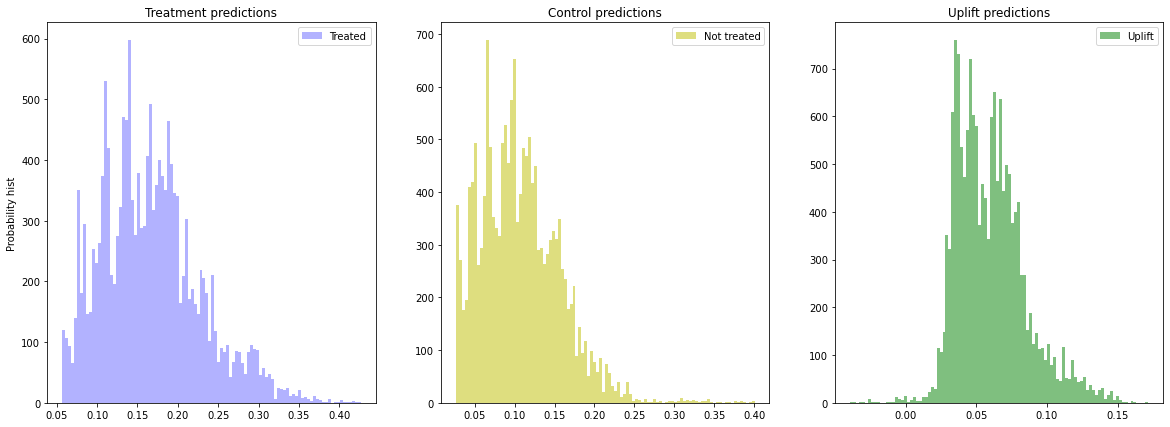

In [8]:
sm = SoloModel(CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_feature))

sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_test)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)

metrics_df = metrics_df.append({
    'model': type(sm).__name__,
    'uplift@10%': sm_score_10,
    'uplift@20%': sm_score_20
}, ignore_index=True)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [9]:
# проверим важность признаков
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,treatment,19.429206
1,is_referral,19.384534
2,used_bogo,13.440138
3,history,10.757888
4,recency,9.902952
5,zip_code,9.496328
6,used_discount,8.878956
7,channel,8.709998


для одной модели лучшим признаком выступает treatment

### 1.2 Трансформация классов

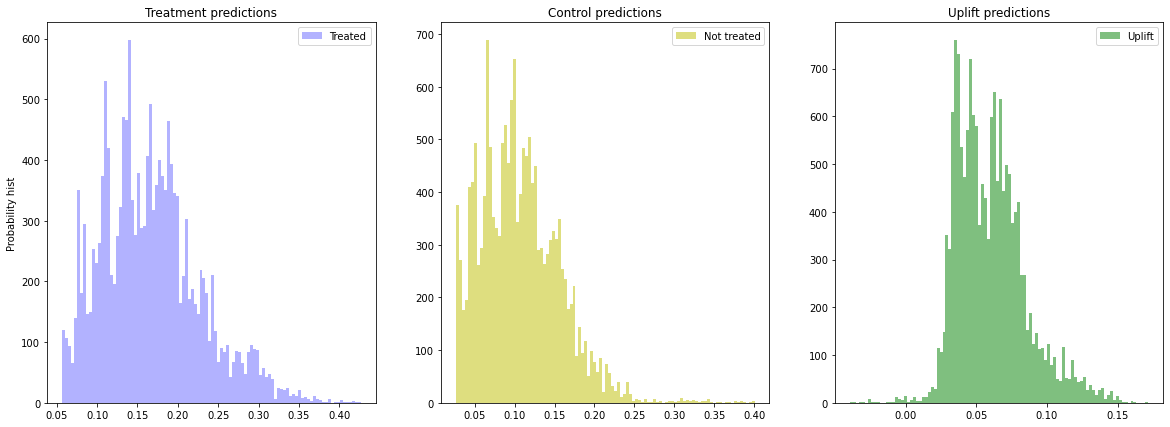

In [10]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_feature))
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.2)

metrics_df = metrics_df.append({
    'model': type(ct).__name__,
    'uplift@10%': ct_score_10,
    'uplift@20%': ct_score_20
}, ignore_index=True)


# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm.trmnt_preds_, ctrl_preds=sm.ctrl_preds_);

In [11]:
# проверим важность признаков
ct_fi = pd.DataFrame({
    'feature_name': ct.estimator.feature_names_,
    'feature_score': ct.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

ct_fi

,feature_name,feature_score
0,used_bogo,22.646666
1,recency,22.139092
2,history,19.414838
3,used_discount,15.060842
4,is_referral,9.643136
5,channel,7.884076
6,zip_code,3.211350


для модели с трансформацией таргета лучшим признаком выступает used_bogo(б/у) и recency	(новизна)

### 2. Две независимые модели

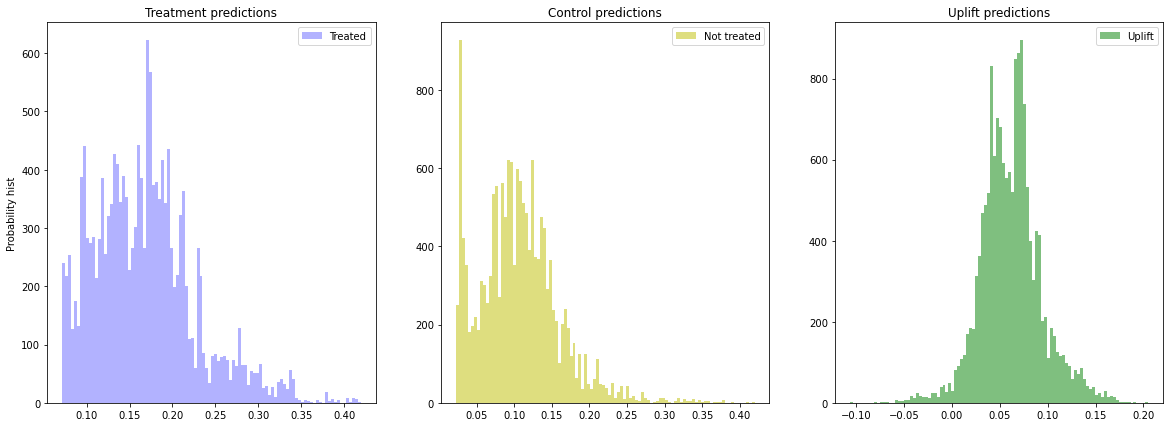

In [12]:
tm = TwoModels(
    CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_feature),
    CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_feature),
    method='vanilla'  # независимые модели
)
tm = tm.fit(
    X_train, y_train, treat_train
)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)

metrics_df = metrics_df.append({
    'model': type(tm).__name__,
    'uplift@10%': tm_score_10,
    'uplift@20%': tm_score_20
}, ignore_index=True)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [13]:
metrics_df

,model,uplift@10%,uplift@20%
0,SoloModel,0.099072,0.088734
1,ClassTransformation,0.091272,0.082507
2,TwoModels,0.104,0.07436


### Модель UpliftTreeClassifier 

In [14]:
!pip install causalml

Defaulting to user installation because normal site-packages is not writeable


In [15]:
from causalml.dataset import make_uplift_classification
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot
from IPython.display import Image

Failed to import duecredit due to No module named 'duecredit'


In [16]:
df = pd.read_csv('HW_data.csv', sep=',')
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [17]:
df.rename(columns={'offer':'treatment', 'conversion':'target'}, inplace=True)
df.loc[df['treatment'] != 'No Offer', 'treatment'] = 1
df.loc[df['treatment'] == 'No Offer', 'treatment'] = 0
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0


In [18]:
df.loc[df['channel'] != 'Web', 'channel'] = 1
df.loc[df['channel'] == 'Web', 'channel'] = 0
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,1,1,0
1,6,329.08,1,1,Rural,1,0,0,0
2,7,180.65,0,1,Surburban,1,0,1,0
3,9,675.83,1,0,Rural,1,0,1,0
4,2,45.34,1,0,Urban,0,0,1,0


In [19]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='zip_code'),
                                                    df['zip_code'],
                                                    test_size=0.25,  
                                                    random_state=42,
                                                    stratify=df['zip_code'])

treat_train = X_train['treatment']
X_train.drop(columns=['treatment'], inplace=True)
treat_val = X_test['treatment']
X_test.drop(columns='treatment', inplace=True)

In [20]:
X_train.head(3)

,recency,history,used_discount,used_bogo,is_referral,channel,target
3557,2,501.27,1,0,1,0,0
38409,9,98.57,1,0,1,1,0
54345,3,29.99,0,1,0,0,0


In [21]:
X_train_tree = pd.concat([X_train.drop('target', 1), 
                          pd.get_dummies(X_train['target'], prefix='target')], 1),
                          
features = [col for col in X_train_tree]

In [23]:
uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())